# Импорт Библиотек

In [9]:
#импорт библиотек
import glob
import os
import pandas as pd
import numpy as np
import json
import docx
from bs4 import BeautifulSoup as bs
import requests
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords
import string
import re
import pyLDAvis.sklearn
import pyLDAvis
import pyLDAvis.lda_model
import pymorphy2
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from tqdm.auto import tqdm, trange
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from yellowbrick.features import RadViz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

# 2.1 Построение модели классификации

In [10]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1213 entries, 0 to 1212

Data columns (total 10 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   name       1213 non-null   object 

 1   raiting    1213 non-null   float64

 2   text       1213 non-null   object 

 3   text_sw    1213 non-null   object 

 4   text_stem  1213 non-null   object 

 5   text_lemm  1213 non-null   object 

 6   keyword    1213 non-null   object 

 7   bigrams    1213 non-null   object 

 8   trigrams   1213 non-null   object 

 9   target     1213 non-null   object 

dtypes: float64(1), object(9)

memory usage: 94.9+ KB


### Разделение выборки на обучающую и тестовую

In [11]:
X = df['text_lemm']
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(df['target'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [13]:
my_tags = df['target'].unique()

### Классификация

__Наивный байесовский классификатор__ (Naive Bayes) - такой классификатор вычисляет вероятность принадлежности объекта к какому-то классу. Эта вероятность вычисляется из шанса, что какое-то событие произойдёт, с опорой на уже на произошедшие события.

__Линейный дискриминантный анализ__ (Linear Discriminant Analysis) - этот метод работает путём уменьшения размерности набора данных, проецируя все точки данных на линию. Потом он комбинирует эти точки в классы, базируясь на их расстоянии от центральной точки.

__Логистическая регрессия__ (logit model) — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.

### Классификация Naive Bayes

In [14]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [15]:
%%time
nb.fit(X_train, y_train)

CPU times: total: 438 ms

Wall time: 1.54 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [16]:
%%time
y_pred = nb.predict(X_test)

CPU times: total: 203 ms

Wall time: 510 ms


Результаты классификации naive bayes

In [17]:
from sklearn.metrics import accuracy_score

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.6703296703296703

                               precision    recall  f1-score   support



Наука, технологии и инновации       0.95      0.50      0.66       151

           Экономика и Бизнес       0.59      0.98      0.74       172

          Образование и Кадры       0.00      0.00      0.00        41



                     accuracy                           0.67       364

                    macro avg       0.51      0.49      0.46       364

                 weighted avg       0.67      0.67      0.62       364




### Линейная классификация

In [18]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [19]:
%%time
sgd.fit(X_train, y_train)

CPU times: total: 719 ms

Wall time: 1.43 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [20]:
%%time
y_pred = sgd.predict(X_test)

CPU times: total: 125 ms

Wall time: 498 ms


результаты линейной классификации

In [21]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7664835164835165

                               precision    recall  f1-score   support



Наука, технологии и инновации       0.85      0.75      0.80       151

           Экономика и Бизнес       0.71      0.90      0.79       172

          Образование и Кадры       0.92      0.29      0.44        41



                     accuracy                           0.77       364

                    macro avg       0.83      0.65      0.68       364

                 weighted avg       0.79      0.77      0.75       364




### Логистическая регрессия

In [22]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1000)),
               ])

In [23]:
%%time
logreg.fit(X_train, y_train)

CPU times: total: 1.61 s

Wall time: 4.96 s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1000, n_jobs=1))])

In [24]:
%%time
y_pred = logreg.predict(X_test)

CPU times: total: 172 ms

Wall time: 481 ms


результаты логистической регрессии

In [25]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7857142857142857

                               precision    recall  f1-score   support



Наука, технологии и инновации       0.85      0.77      0.81       151

           Экономика и Бизнес       0.74      0.89      0.81       172

          Образование и Кадры       0.81      0.41      0.55        41



                     accuracy                           0.79       364

                    macro avg       0.80      0.69      0.72       364

                 weighted avg       0.79      0.79      0.78       364




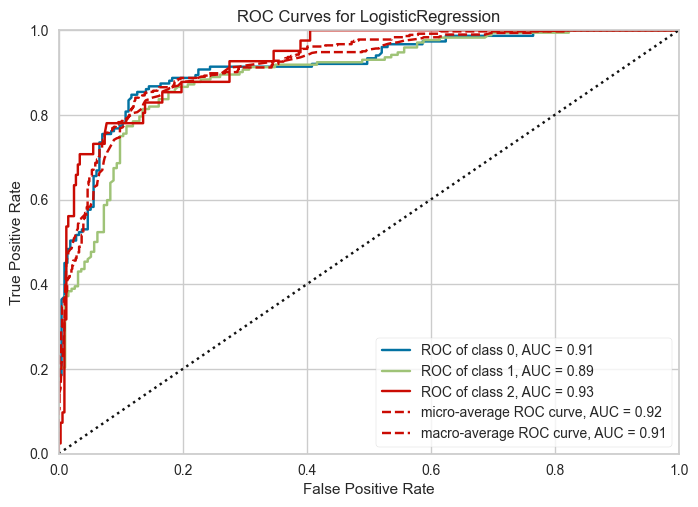

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [26]:
visualizer = ROCAUC(logreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)      
visualizer.show()

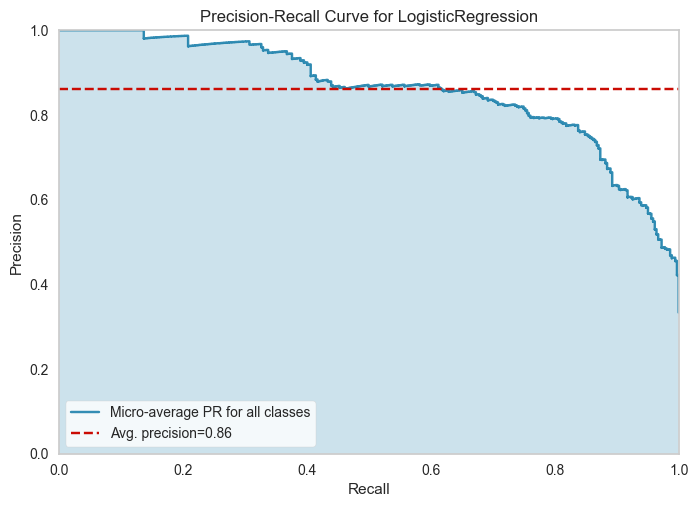

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [27]:
viz = PrecisionRecallCurve(logreg)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

Из трёх классификаторов Логистическая регрессия показала самую высокую точность, поэтому для дальнейшей работы будем использовать результаты этого классификатора.

## 2.2 Оптимизация модели

### Настройка гиперпараметров

GridSearchCV – это очень мощный инструмент для автоматического подбирания параметров для моделей машинного обучения. GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров.

In [28]:
param_range = [4, 20]
param_range_fl = [1, 0.25]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

In [29]:
LR = GridSearchCV(estimator=logreg,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 

In [30]:
LR.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(C=1000, n_jobs=1))]),
             param_grid=[{'clf__C': [1, 0.25], 'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']}],
             scoring='accuracy')

In [31]:
%%time
y_pred = LR.predict(X_test)

CPU times: total: 234 ms

Wall time: 515 ms


In [32]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.804945054945055

                               precision    recall  f1-score   support



Наука, технологии и инновации       0.95      0.75      0.84       151

           Экономика и Бизнес       0.72      0.97      0.83       172

          Образование и Кадры       0.92      0.29      0.44        41



                     accuracy                           0.80       364

                    macro avg       0.87      0.67      0.70       364

                 weighted avg       0.84      0.80      0.79       364




После настройки гиперпараметров точность увеличилась на 0.019. Теперь она состовляет 0.804.

## 2.2.2 Кривые валидации и обучения

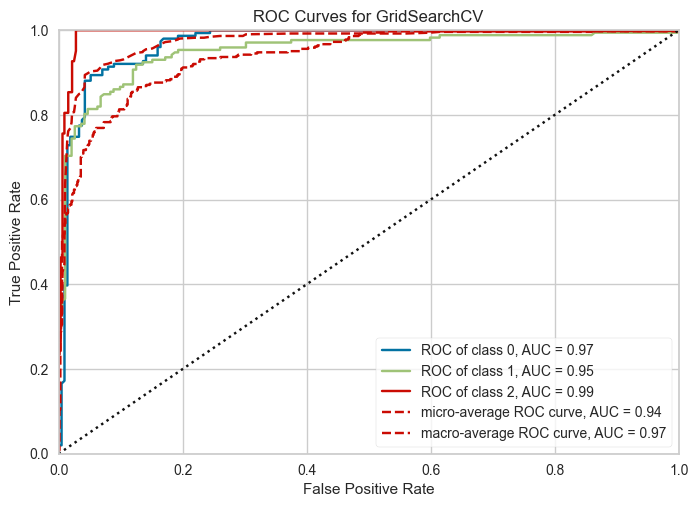

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [33]:
visualizer = ROCAUC(LR)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)      
visualizer.show()

__Логистическая регрессия__ склонна к менее переобучению, поскольку она не имеет множества параметров, которые нужно оптимизировать.

### Проверка предсказывания

In [34]:
LR.predict([df['text_lemm'][1000]])

array([1])

In [36]:
label_encoder.fit_transform(df['target'])[1000]

1

### Сохранение модели

In [37]:
joblib.dump(LR, "model.pkl") #Сохранение модели

['model.pkl']

## Отчет

### 2.1 Построение модели классификации
1. Разбиение выборки на обучающую и тестовую
2. Создание списка номинаций
3. Обучение модели методом классификации Naive Bayes
4. Обучение модели методом линейной классификации
5. Обучение модели методом логистической регрессии

__Вывод__: Мы выполнили разбиение выборки и выполнение оценки трёх моделей классификации: naive bayes ,линейная классификация и логистическая регрессия. Логистическая показала лучший результат.

### 2.2 Оптимизация модели
6. Настройка гиперпараметров
7. Построение кривых валидаций и обучений
8. Проверка предсказывания
9. Сохранение модели

__Вывод:__ Увеличена точность за счёт настройки гиперпараметров, построена кривые валидаций и обучений и проверка предсказывания. В итоге была получена модель, которая может прогнозировать номинацию по тексту статьи.